In [1]:
import json
import numpy as np
import time
import os 
import psutil 
from collections import OrderedDict

import torch
from torch.utils.data import DataLoader
 
import robomimic.utils.train_utils as TrainUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.tensor_utils as TensorUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.file_utils as FileUtils
from robomimic.config import config_factory
from robomimic.algo import algo_factory, RolloutPolicy
from robomimic.utils.log_utils import PrintLogger, DataLogger, flush_warnings
import imageio 

import matplotlib.pyplot as plt

from robomimic.envs.wrappers import EnvWrapper
from copy import deepcopy
import textwrap
import numpy as np
from collections import deque

np.set_printoptions(precision=3, suppress=True)

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /home/franka_deoxys/robomimic/robomimic/scripts/setup_macros.py
)


/home/franka_deoxys/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# ckpt_path = "/home/franka_deoxys/data_franka/lift_blue/policy/trans_epoch_140_lift_blue.pth"
ckpt_path = "/home/franka_deoxys/data_franka/lift_blue/policy/model_epoch_300.pth"
assert os.path.exists(ckpt_path)

In [3]:
device = TorchUtils.get_torch_device(try_to_use_cuda=True)

# restore policy
policy, ckpt_dict = FileUtils.policy_from_checkpoint(ckpt_path=ckpt_path, device=device, verbose=False)
ckpt_dict = FileUtils.maybe_dict_from_checkpoint(ckpt_path=ckpt_path, ckpt_dict=None)
# algo name and config from model dict
algo_name, _ = FileUtils.algo_name_from_checkpoint(ckpt_dict=ckpt_dict)
config, _ = FileUtils.config_from_checkpoint(algo_name=algo_name, ckpt_dict=ckpt_dict, verbose=False)

/home/franka_deoxys/robomimic/robomimic/utils/file_utils.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_dict = torch.load(ckpt_path)



============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['gripper_states', 'joint_states', 'ee_states']
using obs modality: rgb with keys: ['eye_in_hand_rgb', 'agentview_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/franka_deoxys/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franka_deoxys/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Created GPT_Backbone model with number of parameters: 18906112


In [4]:
config.unlock()
config.train.data="/home/franka_deoxys/data_franka/lift_blue/lift_blue_imgs30.hdf5"
config.lock() 
config.train.data

'/home/franka_deoxys/data_franka/lift_blue/lift_blue_imgs30.hdf5'

In [5]:
ObsUtils.initialize_obs_utils_with_config(config)

shape_meta = FileUtils.get_shape_metadata_from_dataset(
    dataset_path=config.train.data,
    all_obs_keys=config.all_obs_keys,
    verbose=False
)
trainset, validset = TrainUtils.load_data_for_training(
    config, obs_keys=shape_meta["all_obs_keys"])
len(trainset.demos)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['gripper_states', 'joint_states', 'ee_states']
using obs modality: rgb with keys: ['eye_in_hand_rgb', 'agentview_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []
SequenceDataset: loading dataset into memory...
100%|██████████| 30/30 [00:00<00:00, 160.44it/s]
SequenceDataset: caching get_item calls...
100%|██████████| 3767/3767 [00:01<00:00, 2218.22it/s]


30

In [6]:
# initialize data loaders
train_loader = DataLoader(
    dataset=trainset,
    sampler=None,
    batch_size=config.train.batch_size,
    shuffle=True,
    num_workers=config.train.num_data_workers,
    drop_last=True
)

In [7]:
batch=next(iter(train_loader))

In [8]:
batch['obs']['agentview_rgb'].shape

torch.Size([100, 10, 120, 120, 3])

In [9]:
model = policy.policy

input_batch = model.process_batch_for_training(batch)
input_batch = model.postprocess_batch_for_training(input_batch, obs_normalization_stats=None)

In [92]:
input_batch['obs']['agentview_rgb'].shape

torch.Size([100, 10, 3, 120, 120])

In [11]:
model.set_train()

In [12]:
epoch=1
info = model.train_on_batch(input_batch, epoch, validate=False)

In [13]:
info['predictions']['log_probs']

tensor([27.4544, 29.2420, 33.3187, 34.6614, 36.5148, 34.2542, 40.8441, 35.1582,
        37.2867, 40.3586, 40.8840, 30.4175, 40.9702, 35.8761, 33.5643, 37.7734,
        32.8059, 26.6060, 35.4593, 33.1531, 38.9156, 42.4689, 37.5167, 36.4718,
        37.3105, 34.2207, 35.8390, 36.9135, 27.8255, 39.7112, 28.3308, 32.1768,
        35.2249, 27.0291, 35.8067, 40.5067, 30.1791, 31.0595, 32.0750, 42.2863,
        29.8422, 35.4120, 36.8997, 31.1337, 39.7720, 40.4967, 38.1884, 39.3062,
        33.6809, 38.6629, 32.6382, 33.1562, 31.1744, 36.0568, 32.1237, 37.6454,
        38.6001, 32.8896, 32.1173, 28.2138, 38.1188, 37.6701, 32.5566, 27.1303,
        29.8183, 32.8366, 35.3553, 40.0643, 31.8365, 36.4301, 40.1167, 40.2483,
        38.9024, 40.0915, 41.3719, 34.8725, 31.9168, 39.0131, 32.4820, 36.8578,
        34.8798, 30.6602, 31.8413, 36.8714, 31.8507, 41.0457, 40.0770, 42.3503,
        37.9751, 30.2602, 41.7487, 38.9444, 39.5371, 38.5094, 32.7607, 34.1003,
        33.1137, 37.0044, 39.1945, 32.15

In [14]:
model.set_eval()

In [15]:
pred = model.get_action(obs_dict=input_batch['obs'], goal_dict=None)

In [16]:
pred.shape

torch.Size([100, 7])

In [17]:
for key in input_batch['obs'].keys():
    print(key, input_batch['obs'][key].shape)

agentview_rgb torch.Size([100, 10, 3, 120, 120])
ee_states torch.Size([100, 10, 16])
eye_in_hand_rgb torch.Size([100, 10, 3, 120, 120])
gripper_states torch.Size([100, 10, 1])
joint_states torch.Size([100, 10, 7])


In [55]:
def stacked_get_init(init_obs, num_frames):
    obs_history = {}
    for k in init_obs:
        obs_history[k] = deque([init_obs[k][None] for _ in range(num_frames)], maxlen=num_frames,)
    obs = { k : np.concatenate(obs_history[k], axis=0) for k in obs_history }
    return obs_history, obs 

def stacked_add_new(obs_history, new_obs):
    for k in new_obs:
        if 'timesteps' in k or 'actions' in k: continue
        obs_history[k].append(new_obs[k][None])

    obs= { k : np.concatenate(obs_history[k], axis=0) for k in obs_history }
    return obs_history, obs 

In [93]:
demo_name = 'demo_1'
# demo_name = 'demo_33'
demo=trainset.hdf5_file['data'][demo_name]
action_org=demo['actions']
obss = demo['obs']
T = action_org.shape[0]

action_org.shape , T 

((119, 7), 119)

In [94]:
num_frames=10

t=0
obs_0={k:obss[k][t] for k in obss.keys()}
for key in obs_0.keys():
    if 'rgb' in key:
        obs_0[key]=obs_0[key].transpose(2, 1, 0)

    # obs_0[key]=obs_0[key][None,:]

init_obs = obs_0
obs_history, obs = stacked_get_init(init_obs, num_frames) 
obs=TensorUtils.to_torch(obs, device=device)

obs['agentview_rgb'].shape, obs['eye_in_hand_rgb'].shape

(torch.Size([10, 3, 120, 120]), torch.Size([10, 3, 120, 120]))

In [89]:
# batch_obs={}
# for key in obs:
#     batch_obs[key]=obs[key][None]
#     print(key, batch_obs[key].shape)
# pred = model.get_action(obs_dict=batch_obs , goal_dict=None)
# pred.shape

In [90]:
# t=1
# obs_t={k:obss[k][t] for k in obss.keys()}
# for key in obs_t.keys():
#     if 'rgb' in key:
#         obs_t[key]=obs_t[key].transpose(2, 1, 0)
 

# obs_history, obs = stacked_add_new(obs_history, obs_t) 
# obs=TensorUtils.to_torch(obs, device=device)

# obs['agentview_rgb'].shape, obs['eye_in_hand_rgb'].shape

In [91]:
action_pred=[]
for t in range(T): 
    obs_t={k:obss[k][t] for k in obss.keys()}
    for key in obs_t.keys():
        if 'rgb' in key:
            obs_t[key]=obs_t[key].transpose(2, 1, 0)
    

    obs_history, obs = stacked_add_new(obs_history, obs_t) 
    obs=TensorUtils.to_torch(obs, device=device)
    batch_obs={}
    for key in obs:
        batch_obs[key]=obs[key][None] 
    pred = model.get_action(obs_dict=batch_obs , goal_dict=None)
    ac=pred[0].detach().cpu().numpy()
    action_pred.append(ac)

action_pred=np.vstack(action_pred)
action_pred.shape

(119, 7)

In [86]:
ac.shape

(7,)

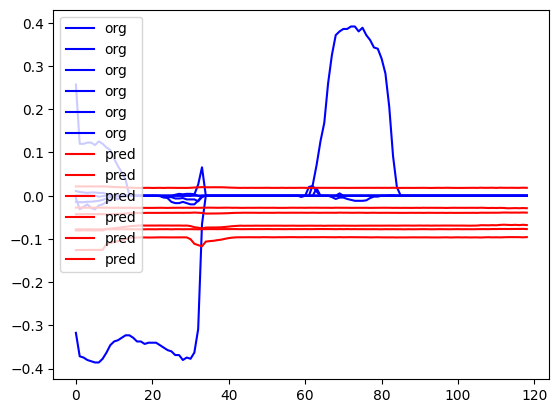

In [84]:
plt.plot(action_org[:,:6], color='blue', label='org')
plt.plot(action_pred[:,:6], color='red', label='pred')
plt.legend()
plt.show()

In [104]:
obs['agentview_rgb'].shape

img=obs['agentview_rgb'][0].permute(2,1,0).detach().cpu().numpy() /255.0
img.shape

(120, 120, 3)

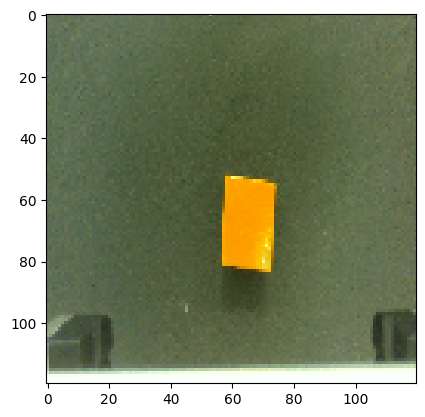

In [105]:
plt.imshow(img)

In [107]:
for key in obs.keys():
    print(key, obs[key].shape)

agentview_rgb torch.Size([10, 3, 120, 120])
ee_states torch.Size([10, 16])
eye_in_hand_rgb torch.Size([10, 3, 120, 120])
gripper_states torch.Size([10, 1])
joint_states torch.Size([10, 7])
